In [8]:
import torch
from torch import nn
from torch.nn import functional as F
from pathlib import Path
import numpy as np
import pandas as pd
import einops
from scipy.io import loadmat
from scipy.io.arff import loadarff
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# base model

In [3]:
class ZeroPad1d(nn.Module):
    '在最后一个维度上，左右进行padding，最后一个维度在TS中通常指Time维'
    def __init__(self, left_pad, right_pad):
        super().__init__()
        self.left_pad = left_pad
        self.right_pad = right_pad
    def forward(self, x):
        assert x.ndim == 3
        return F.pad(x, (self.left_pad, self.right_pad))
    
def conv(in_planes, out_planes, stride=1, kernel_size=3):
    "convolution with padding 自动使用zeros进行padding"
    "same input and output"
    return nn.Conv1d(in_planes, out_planes, kernel_size=kernel_size, stride=stride,
                     padding=(kernel_size - 1) // 2, bias=False)

class ZeroPad1d(nn.Module):
    '在 time 维度上左右进行pad (B, C, T)'
    def __init__(self, pad_left, pad_right):
        super().__init__()
        self.pad_left = pad_left
        self.pad_right = pad_right

    def forward(self, x):
        assert x.ndim == 3
        return F.pad(x, (self.pad_left, self.pad_right))


class BasicBlock1d(nn.Module):
    'Resnet14 和 Resnet18 的卷积模块'
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv(inplanes, planes, stride=stride, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = conv(planes, planes, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)  # [b, c_in, t] -> [b, c_out, t]
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)  # [b, c_out, t] -> [b, c_out, t]
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)  # 一个Relu两用

        return out


class Bottleneck1d(nn.Module):
    """Bottleneck for ResNet52 ..."""
    'c_in -> 4*c_out'
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        kernel_size = 3
        self.conv1 = nn.Conv1d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm1d(planes)
        self.conv2 = nn.Conv1d(planes, planes, kernel_size=kernel_size, stride=stride,
                               padding=(kernel_size - 1) // 2, bias=False)
        self.bn2 = nn.BatchNorm1d(planes)
        self.conv3 = nn.Conv1d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm1d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet1d(nn.Module):
    '''1d adaptation of the torchvision resnet'''

    def __init__(self, block, layers, kernel_size=3, input_channels=2, inplanes=64,
                 fix_feature_dim=False, kernel_size_stem=None, stride_stem=2, pooling_stem=True,
                 stride=2, project=False, dim=500):
        # layers = [2, 2, 2, 2]
        # block = basicblock
        super(ResNet1d, self).__init__()

        self.inplanes = inplanes
        self.project = project
        layers_tmp = []
        if kernel_size_stem is None:
            kernel_size_stem = kernel_size[0] if isinstance(kernel_size, list) else kernel_size  # 3
            # 初始kernel size

        # conv-bn-relu (basic feature extraction)
        # 初始卷积模块，将原始channel 映射到inplanes
        layers_tmp.append(nn.Conv1d(input_channels, inplanes,
                                    kernel_size=kernel_size_stem,
                                    stride=stride_stem,
                                    padding=(kernel_size_stem - 1) // 2, bias=False))
        # [b, 2, 2000] -> [b, 64, 1000]
        # kernel_size=3, stride=2, padding=1, 经过此轮卷积后，序列长度减半
        layers_tmp.append(nn.BatchNorm1d(inplanes))
        layers_tmp.append(nn.ReLU(inplace=True))


        if pooling_stem is True:
            layers_tmp.append(nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
            # 序列长度再减半
        # [b, 64, 1000] -> [b, 64, 500]

        for i, l in enumerate(layers):
            if i == 0:
                layers_tmp.append(self._make_block(block, inplanes, layers[0]))
                # 两个64->64的block，无downsample，由sequential所包裹
            else:
                layers_tmp.append(
                    self._make_block(block, inplanes if fix_feature_dim else (2 ** i) * inplanes, layers[i],
                                     stride=stride))
                # 依次返回64->128, 128->256, 256->512的带downsample的两个block组成的sequential，序列长度一共会经过5次压缩

        self.feature_extractor = nn.Sequential(*layers_tmp)
        if project:
            self.maxpool = nn.AdaptiveMaxPool1d(1)
            self.mlp = nn.Sequential(nn.Linear(self.inplanes, self.inplanes//2), nn.ReLU(inplace=True)
                                , nn.BatchNorm1d(self.inplanes//2), nn.Linear(self.inplanes//2, dim))

    def _make_block(self, block, planes, blocks, stride=1, kernel_size=3):
        # 0: block=basicblock, planes=64, blocks=2, stride=1, expansion of basic block is 1
        # layer 0 不会进行下采样，是 64->64的映射
        down_sample = None

        # 注定会进行下采样
        if stride != 1 or self.inplanes != planes * block.expansion:
            down_sample = nn.Sequential(
                nn.Conv1d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(planes * block.expansion),
            )
            # 下采样，序列长度减半

        layers = []
        layers.append(block(self.inplanes, planes, stride, down_sample))
        self.inplanes = planes * block.expansion

        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        if x.ndim == 4:
            x = x.squeeze(-1)
        out =  self.feature_extractor(x)
        if self.project:
            out = self.maxpool(out).squeeze()
            out = self.mlp(out)
        return out
    
def resnet1d18(**kwargs): # [b, 2, 2000] -> [b, 512, 63], 压缩序列长度，提升特征
    return ResNet1d(BasicBlock1d, [2, 2, 2, 2], **kwargs)

class AdaptiveConcatPool1d(nn.Module):
    "Layer that concats `AdaptiveAvgPool1d` and `AdaptiveMaxPool1d`."

    def __init__(self, sz=None):
        "Output will be 2*sz or 2 if sz is None"
        super().__init__()
        sz = sz or 1
        self.ap, self.mp = nn.AdaptiveAvgPool1d(sz), nn.AdaptiveMaxPool1d(sz)

    def forward(self, x):
        """x is shaped of B, C, T"""
        # [b,c,1] + [b, c, 1] + [b, c, 1] -> [b, 3c, 1]
        return torch.cat([self.mp(x), self.ap(x), x[..., -1:]], 1)

# preprocessing

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [19]:
def plot_channels(data, sample_range):
    for idx in sample_range:
        sample = data[idx]
        fig, pics = plt.subplots(1, 2, figsize=(8, 2))
        for i in np.arange(2):
            c_i = sample[i]
            pics[i].plot(np.arange(c_i.shape[0]), c_i)
        plt.tight_layout()
        plt.show()
        
def plot_signal(data):
    channels = data.shape[0]
    fig, ax = plt.subplots(1, channels*3, figsize=(4, 2))
    length = [0, 2000, 3000, 4000]
    for i in range(channels):
        if i == 0:
            adds = 0
        else:
            adds = 2
        for num in range(len(length)-1):
            ax[i+adds].plot(np.arange(length[num+1]-length[num]), data[i][length[num]:length[num+1]])
            adds += 1
    plt.show()

In [28]:
magnitude_path = r'D:\Jupyter\AD\datasets-ad\battery\resample_dataset_norm\magnitude.npy'
phase_path = r'D:\Jupyter\AD\datasets-ad\battery\resample_dataset_norm\phase.npy'
data_path = r'D:\Jupyter\AD\datasets-ad\battery\resample_dataset_norm\time_freq_data.npy'

# patchlize

In [143]:
def to_patch(data, patch_length):
    temp = einops.rearrange(data, 'b c (n p)->b n c p', p=patch_length)
    return einops.rearrange(temp, 'b n c p->(b n) c p')

def patch2seq(patch, batch):
    mp = nn.AdaptiveMaxPool1d(1)
    return einops.rearrange(mp(patch), '(b n) c 1->b n c', b=batch)

# Normalize

In [12]:
def normalize(x, mode='dataset'):
    'x.shape = [n, c, t]'
    assert mode in ['dataset', 'series'], 'only support normalize through whole dataset or using zscore to each series'
    if mode == 'dataset':
        mean, var = [], []
        for channel in range(x.shape[1]):
            x_c = x[:, channel]
            mean.append(x_c.mean())
            var.append(x_c.var(ddof=1))
        mean, var = np.array(mean).reshape(-1, 1), np.array(var).reshape(-1, 1)  # [c, 1]
        x_norm = (x  - mean) / (var + 1e-8)**0.5
    else:
        mean = x.mean(axis=-1).reshape(x.shape[0], x.shape[1], 1)
        var = x.var(axis=-1, ddof=1).reshape(x.shape[0], x.shape[1], 1)
        x_norm = (x - mean) / (var + 1e-8) **0.5
    return x_norm

def read_ts(cols=2, root=r'D:\Jupyter\AD\datasets-ad\battery\resample', normalize=False, channel_first=True):
    root = Path(root)
    assert root.is_dir() and root.exists()
    assert cols in [1, 2]
    data = []
    index = []
    for f in root.iterdir():
        if f.is_file and f.suffix == '.txt':
            use_col = 1 if cols == 2 else 2
            d = pd.read_csv(f, sep='\t').iloc[:, use_col:].values
            data.append(d)
            index.append(int(f.stem))
    zips = [(d, i) for d, i in zip(data, index)]
    zips.sort(key=lambda x:x[1])
    data = np.concatenate([d.reshape(1, d.shape[0], d.shape[1]) for d, _ in zips])
    data =  normalize(data, 'series') if normalize else data
    return np.transpose(data, (0, 2, 1)) if channel_first else data

In [4]:
data = read_ts()

In [11]:
norm_data = normalize(data, 'series')

In [8]:
path1 = Path(r'D:\Jupyter\AD\datasets-ad\battery\resample_dataset_norm')
path2 = Path(r'D:\Jupyter\AD\datasets-ad\battery\resample_norm')
path1.mkdir(exist_ok=True)
path2.mkdir(exist_ok=True)

In [12]:
for i, each in enumerate(norm_data):
    file = pd.DataFrame({'I':each[0], 'V':each[1]})
    file.to_csv(path2/f'{i+1}.txt')
np.save(path2/'series_norm_data.npy', norm_data)

In [4]:
data = np.load(r'D:\Jupyter\AD\datasets-ad\battery\resample_dataset_norm\time_freq_data_dataset_norm.npy')

In [22]:
data = data[:, 1:]

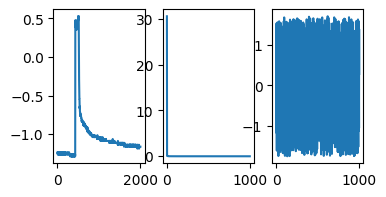

In [24]:
plot_signal(data[100])